# Data Preparation

In this notebook the goal is to prepare the dataset (csv or excel) to train the Random Forest Classifier for land cover classification. The dataset would be composed of : 

- annual fractional cover (bs, pv, npv)
- RGB
- NDVI, NDWI, NDWI, EVI
- DEM (elevation)
- RADAR data (sentinel 1)
- monthly NDVI
- seasonal fractional cover

In [1]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio
from matplotlib.patches import Patch
import seaborn as sns

import os
import sys

from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
import rioxarray
from dea_tools.dask import create_local_dask_cluster, create_dask_gateway_cluster

#client = create_local_dask_cluster(return_client=True)
from dask.distributed import Client as DaskClient

dask_client = DaskClient(n_workers=2,
            threads_per_worker=16,
            memory_limit='30GB',)

2025-08-27 03:59:31,117 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f3e78ac6216a84f8a81d6ce8684da9a9 initialized by task ('rechunk-merge-rechunk-transfer-a4ccaf6cbabe979b847541e332ea2d2a', 0, 6, 4, 0, 6, 4) executed on worker tcp://127.0.0.1:41875
2025-08-27 03:59:31,564 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9b33c675455d253eeb5fd4fa3fc0d031 initialized by task ('rechunk-merge-rechunk-transfer-a4ccaf6cbabe979b847541e332ea2d2a', 0, 6, 2, 0, 6, 2) executed on worker tcp://127.0.0.1:45131
2025-08-27 03:59:32,172 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle af1e8f11b6c71447f5db8dd80ee012d9 initialized by task ('rechunk-merge-rechunk-transfer-a4ccaf6cbabe979b847541e332ea2d2a', 0, 6, 3, 0, 6, 3) executed on worker tcp://127.0.0.1:45131
2025-08-27 03:59:33,278 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4079431b4d80e0cf4b392b827cb3d870 initialized by task ('rechunk-merge-rechunk-transfer-a4ccaf6cbabe979b847541e332ea2d2a', 0, 

In [2]:
catalog = "https://stac.staging.digitalearthpacific.io"
clients = Client.open(catalog)
collections = clients.get_collections()

In [3]:
# AOI FIJI CENTRAL + WESTERN
divisions = ['Central', 'Western']

# Fetch boundaries
gdfs = [dep.get_country_admin_boundary('Fiji', 'Division', division) for division in divisions]

# Union into one AOI
aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
aoi_union = aoi.unary_union

# Bounding box of the union
bbox = aoi_union.bounds 
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [95]:
# AOI COOK ISLANDS
aoi = dep.get_country_admin_boundary('Cook Islands', 'Island Council', "Rarotonga")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')

In [22]:
# AOI MARSHALL ISLANDS
aoi = dep.get_country_admin_boundary('Marshall Islands', 'Atoll', "Majuro")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')


In [43]:
# AOI PALAU 

# List of Palau states

states = [
    "Aimeliik",
    "Airai",
    "Melekeok",
    "Ngaraard",
    "Ngardmau",
    "Ngatpang",
    "Ngchesar",
    "Ngeremlengui",
    "Ngiwal", 
    "Ngarchelong",
    "Koror"
]


gdfs = [dep.get_country_admin_boundary('Palau', 'State', state) for state in states]

aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
aoi_union = aoi.unary_union

# Bounding box of the union
bbox = aoi_union.bounds 
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

## ANNUAL FRACTIONAL COVER

In [44]:
items = clients.search(collections=["dep_ls_fc_summary_annual"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 3 items


In [45]:
items = clients.search(
    collections=["dep_ls_fc_summary_annual"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)


data = dep.do_coastal_clip(aoi, data, buffer=0.001)
fc = data[["bs_pc_50", "pv_pc_50", "npv_pc_50"]]


if not fc.rio.crs:
    print('change')
    fc = fc.rio.write_crs("EPSG:32660") 
    # COOK EPSG : 32604 / MARSHALL EPSG :32659 / FIJI EPSG : 32660 / PALAOS EPSG : 32653

# Reproject to EPSG:4326
fc= fc.rio.reproject("EPSG:4326") 
fc = fc.where(fc != 255, np.nan)


print(fc)

<xarray.Dataset> Size: 46MB
Dimensions:      (time: 1, y: 2451, x: 1571)
Coordinates:
  * x            (x) float64 13kB 134.2 134.2 134.2 134.2 ... 134.6 134.6 134.6
  * y            (y) float64 20kB 7.76 7.759 7.759 7.759 ... 7.101 7.101 7.1 7.1
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    bs_pc_50     (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    pv_pc_50     (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    npv_pc_50    (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan


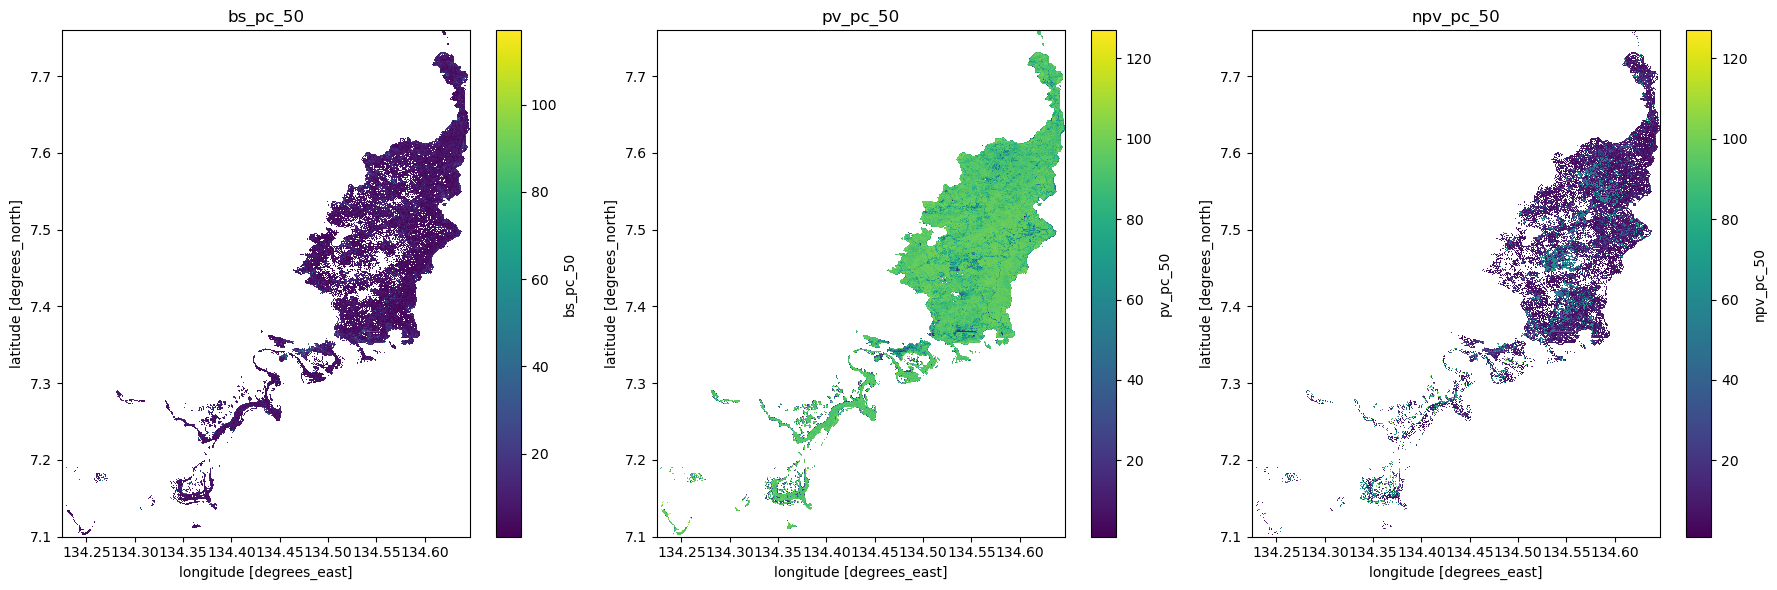

In [46]:
bands = ["bs_pc_50", "pv_pc_50", "npv_pc_50"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, band in enumerate(bands):
    fc[band].isel(time=0).plot(ax=axes[i], cmap="viridis")
    axes[i].set_title(band)

plt.tight_layout()
plt.show()

## RGB + INDEXES (NDVI, NDWI, NDBI, ...)

In [47]:
items = clients.search(collections=["dep_s2_geomad"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 12 items


In [48]:
items = clients.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks, like = fc.odc.geobox)
spectral = data[["red", "blue", "green", "nir08", "swir16", "emad", "smad", "bcmad"]]
spectral = dep.do_coastal_clip(aoi, spectral , buffer=0.001)
spectral = spectral.where(spectral != 0, np.nan)


print(spectral)

<xarray.Dataset> Size: 200MB
Dimensions:      (time: 1, latitude: 2450, longitude: 1571)
Coordinates:
  * latitude     (latitude) float64 20kB 7.76 7.759 7.759 ... 7.101 7.101 7.1
  * longitude    (longitude) float64 13kB 134.2 134.2 134.2 ... 134.6 134.6
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    red          (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 2048, 1571), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 2048, 1571), meta=np.ndarray>
    green        (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 2048, 1571), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 2048, 1571), meta=np.ndarray>
    swir16       (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 2048, 1571), meta=np.ndarray>
    emad         (time, latitude, longitude) float32 15MB dask.array<chunksize=(1,

In [49]:


def add_indices(data: xr.Dataset) -> xr.Dataset:
    """
    Add common spectral indices to a Sentinel-2 xarray Dataset.
    Works with bands: red, green, blue, nir08, swir16.
    """
    # Ensure float32 for calculations
    for band in ["red", "green", "blue", "nir08", "swir16"]:
        data[band] = data[band].astype("float64")

    # NDVI = (NIR - Red) / (NIR + Red)
    data["ndvi"] = (data["nir08"] - data["red"]) / (data["nir08"] + data["red"])

    # MNDWI = (Green - SWIR) / (Green + SWIR)
    data["mndwi"] = (data["green"] - data["swir16"]) / (data["green"] + data["swir16"])

    # EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
    data["evi"] = (2.5 * (data["nir08"] - data["red"])) / (data["nir08"] + 6 * data["red"] - 7.5 * data["blue"] + 1)

    # SAVI = (1 + L) * (NIR - Red) / (NIR + Red + L), L=0.5
    L = 0.5
    #data["savi"] = (1 + L) * (data["nir08"] - data["red"]) / (data["nir08"] + data["red"] + L)

    # BSI (Bare Soil Index) = (SWIR + Red - NIR - Blue) / (SWIR + Red + NIR + Blue)
    #data["bsi"] = (data["swir16"] + data["red"] - data["nir08"] - data["blue"]) / (
    #    data["swir16"] + data["red"] + data["nir08"] + data["blue"]
    #)

    # NDMI (Normalized Difference Moisture Index) = (NIR - SWIR) / (NIR + SWIR)
    #data["ndmi"] = (data["nir08"] - data["swir16"]) / (data["nir08"] + data["swir16"])

    # NDBI (Normalized Difference Built-up Index) = (SWIR - NIR) / (SWIR + NIR)
    data["ndbi"] = (data["swir16"] - data["nir08"]) / (data["swir16"] + data["nir08"])

    return data


In [50]:
spectral = add_indices(spectral)

if not spectral.rio.crs:
    spectral = spectral.rio.write_crs("EPSG:3832")  

spectral = spectral.rio.reproject("EPSG:4326")

print(spectral)

<xarray.Dataset> Size: 323MB
Dimensions:      (x: 1571, y: 2450, time: 1)
Coordinates:
  * x            (x) float64 13kB 134.2 134.2 134.2 134.2 ... 134.6 134.6 134.6
  * y            (y) float64 20kB 7.76 7.759 7.759 7.759 ... 7.101 7.101 7.1
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    red          (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    nir08        (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    swir16       (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    emad         (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    smad         (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    bcmad        (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    ndvi         (time, y, 

In [51]:
spectral.ndvi.isel(time=0).odc.explore()

## SEASONNAL FRACTIONAL COVER 

In [52]:
####################################################################
# JANUARY - APRIL FC 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = clients.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-01-01/2024-04-30").item_collection()

items = clients.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
# should I change the chunks to dask_chunks????
data_temoin = load(items, chunks=chunks, groupby = 'solar_day', like = fc.odc.geobox) 
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = clients.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks,  groupby = 'solar_day', like = fc.odc.geobox)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
merged = data.merge(data_temoin) # remain on dask youpiiiii
masked = merged.where(merged['water'] != 1, np.nan)


#########################################################################
# Compute the seasonal median
clean = masked.where(masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

fc_jan_apr = xr.Dataset(
    {
        "bs_jan_apr": bs_median,
        "pv_jan_apr": pv_median,
        "npv_jan_apr": npv_median
    }
)

####################################################################
# Reproject to EPSG:4326
if not fc_jan_apr.rio.crs:
    fc_jan_apr = fc_jan_apr.rio.write_crs("EPSG:32660")
    # COOK EPSG : 32604 / MARSHALL EPSG :32659 / FIJI EPSG : 32660 / PALAOS EPSG : 32653
fc_jan_apr= fc_jan_apr.rio.reproject("EPSG:4326")

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
fc_jan_apr = fc_jan_apr.expand_dims(time=[time_coord])
fc_jan_apr = fc_jan_apr.transpose('time', 'y', 'x')


print(fc_jan_apr)

<xarray.Dataset> Size: 46MB
Dimensions:      (time: 1, x: 1571, y: 2450)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * x            (x) float64 13kB 134.2 134.2 134.2 134.2 ... 134.6 134.6 134.6
  * y            (y) float64 20kB 7.76 7.759 7.759 7.759 ... 7.101 7.101 7.1
    spatial_ref  int64 8B 0
Data variables:
    bs_jan_apr   (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    pv_jan_apr   (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan
    npv_jan_apr  (time, y, x) float32 15MB nan nan nan nan ... nan nan nan nan


In [53]:
####################################################################
# MAY - AUGUST FC 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = clients.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-05-01/2024-08-31").item_collection()

items = clients.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-05-01/2024-08-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks, groupby = 'solar_day', like = fc.odc.geobox)
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = clients.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-05-01/2024-08-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks, groupby = 'solar_day', like = fc.odc.geobox)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
merged = data.merge(data_temoin) # dask 
masked = merged.where(merged['water'] != 1, np.nan)
        
#########################################################################
# compute the seasonal median
clean = masked.where(masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

fc_may_aug = xr.Dataset(
    {
        "bs_may_aug": bs_median,
        "pv_may_aug": pv_median,
        "npv_may_aug": npv_median
    }
)

####################################################################
# Reproject to EPSG:4326
if not fc_may_aug.rio.crs:
    fc_may_aug = fc_may_aug.rio.write_crs("EPSG:32660")
    # COOK EPSG : 32604 / MARSHALL EPSG :32659 / FIJI EPSG : 32660 / PALAOS EPSG : 32653

fc_may_aug= fc_may_aug.rio.reproject("EPSG:4326")

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
fc_may_aug = fc_may_aug.expand_dims(time=[time_coord])
fc_may_aug = fc_may_aug.transpose('time', 'y', 'x')


print(fc_may_aug)

<xarray.Dataset> Size: 92MB
Dimensions:      (time: 1, x: 1571, y: 2450)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * x            (x) float64 13kB 134.2 134.2 134.2 134.2 ... 134.6 134.6 134.6
  * y            (y) float64 20kB 7.76 7.759 7.759 7.759 ... 7.101 7.101 7.1
    spatial_ref  int64 8B 0
Data variables:
    bs_may_aug   (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    pv_may_aug   (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    npv_may_aug  (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan


In [54]:
####################################################################
# SEPTEMBER - DECEMBER FC 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = clients.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-09-01/2024-12-31").item_collection()

items = clients.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-09-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks, groupby = 'solar_day', like = fc.odc.geobox)
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = clients.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-09-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks, groupby = 'solar_day', like = fc.odc.geobox)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
merged = data.merge(data_temoin) # dask 
masked = merged.where(merged['water'] != 1, np.nan)
        
#########################################################################
# compute the seasonal median
clean = masked.where(masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

fc_sep_dec = xr.Dataset(
    {
        "bs_sep_dec": bs_median,
        "pv_sep_dec": pv_median,
        "npv_sep_dec": npv_median
    }
)

####################################################################
# Reproject to EPSG:4326
if not fc_sep_dec.rio.crs:
    fc_sep_dec = fc_sep_dec.rio.write_crs("EPSG:32660")
    # COOK EPSG : 32604 / MARSHALL EPSG :32659 / FIJI EPSG : 32660 / PALAOS EPSG : 32653
fc_sep_dec = fc_sep_dec.rio.reproject("EPSG:4326")

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
fc_sep_dec = fc_sep_dec.expand_dims(time=[time_coord])
fc_sep_dec = fc_sep_dec.transpose('time', 'y', 'x')

print(fc_sep_dec)

<xarray.Dataset> Size: 92MB
Dimensions:      (time: 1, x: 1571, y: 2450)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
  * x            (x) float64 13kB 134.2 134.2 134.2 134.2 ... 134.6 134.6 134.6
  * y            (y) float64 20kB 7.76 7.759 7.759 7.759 ... 7.101 7.101 7.1
    spatial_ref  int64 8B 0
Data variables:
    bs_sep_dec   (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    pv_sep_dec   (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan
    npv_sep_dec  (time, y, x) float64 31MB nan nan nan nan ... nan nan nan nan


## DEM 

In [55]:
# run_task.py
from dep_tools.searchers import PystacSearcher

def get_dem_searcher():
    """Return a PystacSearcher for DEM (Copernicus DEM)."""
    return PystacSearcher(
        catalog="https://earth-search.aws.element84.com/v1",
        collections=["cop-dem-glo-30"],
    )

In [56]:

dem_searcher = get_dem_searcher()

# Run searches
gdf = fc.odc.geobox
dem_items = dem_searcher.search(gdf)

print("DEM items:", len(dem_items))

DEM items: 1


In [57]:
from dep_tools.loaders import OdcLoader
loader = OdcLoader(
    chunks=dict( x=2048, y=2048),
)


dem_data = loader.load(dem_items, gdf)
dem_data = dep.do_coastal_clip(aoi, dem_data, buffer=0.001)

dem_data = dem_data.rename({
    "latitude": "y",
    "longitude": "x"
})
dem_data = dem_data.assign_coords(time=[np.datetime64("2024-01-01")])
dem_data = dem_data.rename({"data": "dem"})
print(dem_data)

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 2450, x: 1571, time: 1)
Coordinates:
  * y            (y) float64 20kB 7.76 7.759 7.759 7.759 ... 7.101 7.101 7.1
  * x            (x) float64 13kB 134.2 134.2 134.2 134.2 ... 134.6 134.6 134.6
    spatial_ref  int64 8B 0
  * time         (time) datetime64[s] 8B 2024-01-01
Data variables:
    dem          (time, y, x) float32 15MB dask.array<chunksize=(1, 2048, 1571), meta=np.ndarray>


In [58]:
dem_data.dem.isel(time=0).odc.explore()

## Create dataset (data + label) for training

In [59]:
datasets = xr.merge([fc,  spectral, dem_data, fc_jan_apr, fc_may_aug, fc_sep_dec], join='left')

In [64]:
# Interpolate on points 

gdf = gpd.read_file("./data/label/lulc_palau.gpkg")

# Get coords
coords_x = gdf.geometry.x.values
coords_y = gdf.geometry.y.values
n_points = len(gdf)


sampled = datasets.interp(
    x=("points", coords_x),
    y=("points", coords_y),
    method="nearest"
)

sampled

<xarray.Dataset> Size: 86kB
Dimensions:      (time: 1, points: 486)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
    x            (points) float64 4kB 134.6 134.6 134.6 ... 134.6 134.6 134.6
    y            (points) float64 4kB 7.367 7.367 7.367 ... 7.362 7.362 7.362
Dimensions without coordinates: points
Data variables: (12/25)
    bs_pc_50     (time, points) float32 2kB 30.0 3.0 39.0 8.0 ... 15.0 15.0 15.0
    pv_pc_50     (time, points) float32 2kB 22.0 52.0 18.0 77.0 ... 6.0 6.0 6.0
    npv_pc_50    (time, points) float32 2kB 47.0 43.0 42.0 ... 89.0 89.0 89.0
    red          (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    blue         (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    green        (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    ...           ...
    bs_may_aug   (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    pv_may_aug   (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    npv_may_aug  (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    bs_sep_dec   (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    pv_sep_dec   (time, points) float64 4kB nan nan nan nan ... nan nan nan nan
    npv_sep_dec  (time, points) float64 4kB nan nan nan nan ... nan nan nan nan

In [70]:
df = sampled.to_dataframe().reset_index()

df["class_id"] = gdf["class_id"].values 
df["lulc"] = gdf["lulc"].values
df = df.drop(["time", "points"], axis=1)
df = df.dropna(axis = 0) 
df.head()


,bs_pc_50,pv_pc_50,npv_pc_50,spatial_ref,red,blue,green,nir08,swir16,emad,...,bs_may_aug,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,x,y,class_id,lulc
12,18.0,68.0,13.0,0,1086.0,825.0,1273.0,4645.0,3261.0,905.089966,...,13.0,66.0,20.0,31.5,61.0,27.5,134.556356,7.381919,4,buildup
18,20.0,16.0,85.0,0,2953.0,2889.0,2847.0,3044.0,3292.0,1138.117798,...,50.0,25.0,44.5,37.0,31.0,78.5,134.455126,7.336010,4,buildup
19,31.0,19.0,50.0,0,2845.0,2770.0,2854.0,3558.0,3782.0,1440.936035,...,26.0,23.5,56.0,27.5,27.0,53.0,134.452772,7.334459,4,buildup
26,17.0,32.0,53.0,0,1378.0,1207.0,1341.0,2064.0,2578.0,706.434387,...,16.0,32.5,55.0,19.0,29.0,62.0,134.471144,7.341187,4,buildup
28,30.0,16.0,43.0,0,1233.0,1197.0,1306.0,2278.0,2469.0,789.638733,...,15.0,28.0,79.0,32.0,28.5,64.5,134.474216,7.341852,4,buildup


In [71]:
gdf_out = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["x"], df["y"]),
    crs="EPSG:4326"   
)

gdf_out = gdf_out.drop(columns=["x", "y"])

# Save as GeoPackage and CSV
out_path = "./data/preparation/palau_dataset.gpkg"
gdf_out.to_file(out_path, driver="GPKG")
gdf_out.to_csv('./data/preparation/palau_dataset.csv')

## FOR LATER MAYBE

## SENTINEL 1 (RADAR)

In [20]:
items = clients.search(collections=["dep_s1_geomad"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 4 items


In [21]:
items = clients.search(
    collections=["dep_s1_geomad"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
radar = load(items, chunks=chunks)

radar = dep.do_coastal_clip(aoi, radar, buffer=0.001)

print(radar)

<xarray.Dataset> Size: 5GB
Dimensions:      (y: 12291, x: 11093, time: 1)
Coordinates:
  * y            (y) float64 98kB -1.952e+06 -1.952e+06 ... -2.075e+06
  * x            (x) float64 89kB 3.092e+06 3.092e+06 ... 3.203e+06 3.203e+06
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    vh           (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    vv           (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    emad         (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    smad         (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    bcmad        (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    count        (time, y, x) uint16 273MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    mean_vh      (time, y, x) float32 545MB dask.array<chunksize=(1, 1787,

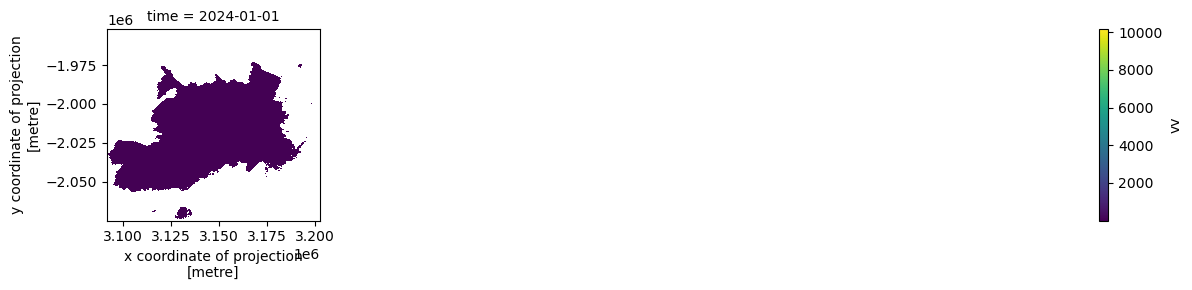

In [18]:
dep.visualise(radar['vv'])

In [ ]:
# IF 0 ITEMS FOUND ON DEP STAC API STAGING 
from dep_tools.searchers import PystacSearcher
from datetime import date

def get_sentinel_searcher():
    today = date.today().isoformat()
    return PystacSearcher(
        catalog = "https://planetarycomputer.microsoft.com/api/stac/v1",
        collections=["sentinel-1-rtc"],  
        datetime="2020-01-01/2024-12-31",
    )


s2_searcher = get_sentinel_searcher()
items = s2_searcher.search(gdf)  
print(len(items), "items found")

## GLCM TEXTURE 

In [ ]:
import dask.array as da
from skimage.feature import graycomatrix, graycoprops

def glcm_features(patch, distances=[1, 2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=32):
    # Skip NaNs / uniform patches
    if np.isnan(patch).any() or patch.max() == patch.min():
        return {k: np.nan for k in [
            "contrast","dissimilarity","homogeneity",
            "energy","correlation","entropy","ASM"
        ]}

    # Scale NDVI-like values [-1,1] → [0,levels-1]
    patch_scaled = np.clip(((patch + 1) * (levels-1)/2).astype(np.uint8), 0, levels-1)

    glcm = graycomatrix(
        patch_scaled,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True,
    )

    # Average over angles and distances
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    asm = graycoprops(glcm, 'ASM').mean()

    # Entropy
    p = glcm / glcm.sum()
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))

    return {
        "contrast": contrast,
        "dissimilarity": dissimilarity,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation,
        "entropy": entropy,
        "ASM": asm,
    }

def compute_glcm_patchwise(band_da, window_size=31, levels=32):
    """
    band_da: xarray.DataArray with dims (y, x)
    window_size: odd integer (e.g., 15, 31, 41)
    """
    ysize, xsize = band_da.shape[-2:]
    pad_y = int((window_size - ysize % window_size) % window_size)
    pad_x = int((window_size - xsize % window_size) % window_size)

    # Pad correctly: ((top,bottom), (left,right))
    padded = da.pad(band_da.data, ((0, pad_y), (0, pad_x)), mode="reflect")

    # Split into patches
    reshaped = padded.reshape(
        padded.shape[0] // window_size, window_size,
        padded.shape[1] // window_size, window_size
    )
    patches = reshaped.swapaxes(1, 2) 

    # Compute GLCM for each patch
    n_py, n_px, _, _ = patches.shape
    features = {k: np.full((n_py, n_px), np.nan, dtype=np.float32)
                for k in ["contrast","dissimilarity","homogeneity",
                          "energy","correlation","entropy","ASM"]}

    for i in range(n_py):
        for j in range(n_px):
            patch = patches[i, j].compute()
            feats = glcm_features(patch, levels=levels)
            for k, v in feats.items():
                features[k][i, j] = v

    # Expand back to full resolution
    def upscale(arr):
        return np.repeat(np.repeat(arr, window_size, axis=0), window_size, axis=1)[:ysize, :xsize]

    ds = xr.Dataset(
        {k: (("y", "x"), upscale(v)) for k, v in features.items()},
        coords={"y": band_da.y, "x": band_da.x}
    )

    return ds


######################################################################
# Example usage
# Assume spectral["ndvi"] is (y,x)
ndvi = spectral["ndvi"]
ndvi = spectral["ndvi"].squeeze("time", drop=True)

# Try two scales (multi-scale texture)
glcm = compute_glcm_patchwise(ndvi, window_size=31, levels=32)

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
glcm = glcm.expand_dims(time=[time_coord])


print(glcm)


In [ ]:
dep.visualise(glcm['ASM'])